# Example Notebook for Keysight Network Analyzers

This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight network analyzers. The driver is implemented to be generic as possible, with individual instrument drivers filling in only the hardware limits of the instrument, so although this example uses the N5222B, the concepts and code should work for any keysight network analyzer.

In [1]:
%matplotlib inline

In [2]:
# Import Dependencies

import numpy as np 
import logging
import matplotlib.pyplot as plt

# qcodes imports
import qcodes as qc
from qcodes.dataset.data_set import new_data_set
from qcodes.dataset.experiment_container import new_experiment, load_experiment_by_name
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument_drivers.Keysight.N5222B import N5222B

## Connect to the instrument


In [3]:
pna = N5222B('pna', 'GPIB0::16::INSTR')

Connected to: Keysight Technologies N5225B (serial:MY57181138, firmware:A.12.85.04) in 0.94s


In [4]:
pna.window

[<N52xxWindow: pna_window1 of N5222B: pna>,
 <N52xxWindow: pna_window2 of N5222B: pna>]

In [5]:
pna.channel

[<Channel type <N5222B: pna>: 1>,
 <Channel type <N5222B: pna>: 2>,
 <Channel type <N5222B: pna>: 3>,
 <Channel type <N5222B: pna>: 4>,
 <Channel type <N5222B: pna>: 5>]

In [6]:
pna.channel[0].delete()

In [7]:
pna.channel

[<Channel type <N5222B: pna>: 2>,
 <Channel type <N5222B: pna>: 3>,
 <Channel type <N5222B: pna>: 4>,
 <Channel type <N5222B: pna>: 5>]

In [8]:
pna.list_existing_channel_numbers()

[2, 3, 4, 5]

## Measuring

Below we see how we can perform a measurement

In [9]:
qc.initialise_database()

# Start experiment
exp_name = 'PNA_Example_N5222B'
sample_name = 'sample_bar_code'
try:
    exp = load_experiment_by_name(exp_name, sample=sample_name)
    print('Experiment loaded. Last ID no:', exp.last_counter)
except ValueError:
    exp = new_experiment(exp_name, sample_name)
    print('Starting new experiment.')

Experiment loaded. Last ID no: 53


In [10]:
pna.reset_instrument()

Starting experimental run with id: 109


([<matplotlib.axes._subplots.AxesSubplot at 0x174e28d4fd0>,
 [None, None, None, None])

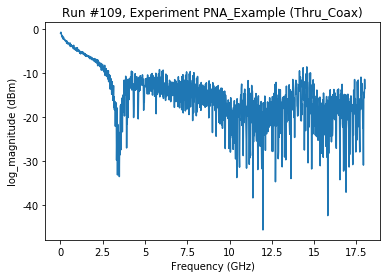

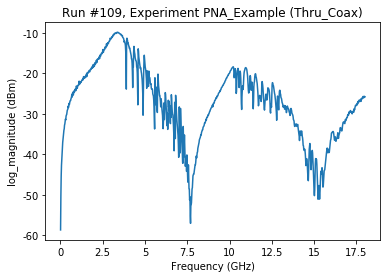

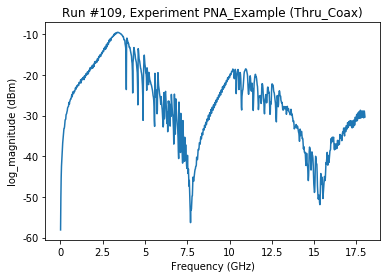

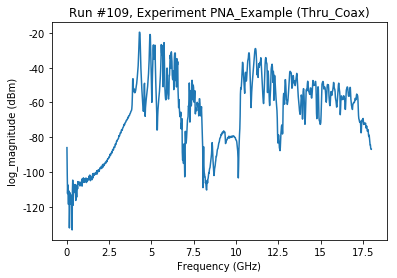

In [11]:
pna.delete_all_traces()

# Note: adding a window is strictly speaking not necessary for a measurement, but often experimantalists 
# want to see what is going on by lookin at the instrument display
window = pna.add_window()
channel = pna.add_channel()

trace_s21 = channel.add_trace("S21")  
trace_s11 = channel.add_trace("S11")
trace_s43 = channel.add_trace("S43")

# Lets add another trace but 'change our minds' later about the type 
trace_sxy = channel.add_trace("S44")
trace_sxy.measurement_type("S32")

window.add_channel(channel) # This will add all traces in the channel to the window

# Run a measurement
fstart = 10e6  # Hz
fstop = 18e9 # Hz 
points = 1001

channel.power(10)
channel.start(fstart)
channel.stop(fstop)
channel.points(points)

# Enable 2 averages, and set IF BW to 1kHz
channel.if_bandwidth(1e3)
channel.averages_enabled(True)
channel.averages(2)

meas = Measurement()
meas.register_parameter(trace_s11.log_magnitude)
meas.register_parameter(trace_s21.log_magnitude)
meas.register_parameter(trace_s43.log_magnitude)
meas.register_parameter(trace_sxy.log_magnitude)

with meas.run() as datasaver:
    channel.run_sweep(averages=10)
    
    datasaver.add_result((trace_s11.log_magnitude, trace_s11.log_magnitude()))
    datasaver.add_result((trace_s21.log_magnitude, trace_s21.log_magnitude()))
    datasaver.add_result((trace_s43.log_magnitude, trace_s43.log_magnitude()))
    datasaver.add_result((trace_sxy.log_magnitude, trace_sxy.log_magnitude()))
    
plot_by_id(datasaver.run_id)

## Getting SNP data 

We can get all snp data in one go as well

In [13]:
# Define traces for all S-parameters 
traces = [channel.add_trace(f"S{x}{y}") for x in range(1, 5) for y in range(1, 5)]

channel.run_sweep(averages=2)
snp_data = channel.get_snp_data()

Reorganize the data in a convinient way 

In [14]:
snp_header = ["frequency"] + [f"S{x}{y}_{reim}" for x in range(1, 5) for y in range(1, 5) for reim in ["re", "im"]]
snp_data_dict = {key: data for key, data in zip(snp_header, snp_data.reshape(-1, points))}

# Notice that the length of the header is n * n * 2 + 1. The total length of the snp data is therefore (2*n**2+1)*n_freq, where 
# n_freq is the number of frequency points in our sweep. 

Extract the S11 magnitude from the snp data and verify that it is consistent with the plots shown earlier

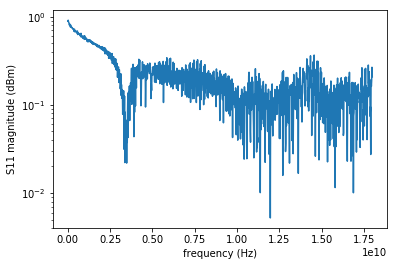

In [15]:
s11_magnitude = np.absolute(snp_data_dict["S11_re"] + 1j * snp_data_dict["S11_im"])

fig, ax = plt.subplots(1)
line, = ax.plot(snp_data_dict["frequency"], s11_magnitude)
ax.set_yscale('log')
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("S11 magnitude (dBm)")

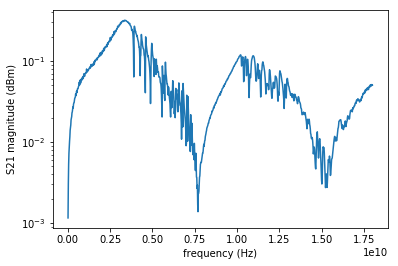

In [16]:
s21_magnitude = np.absolute(snp_data_dict["S21_re"] + 1j * snp_data_dict["S21_im"])

fig, ax = plt.subplots(1)
line, = ax.plot(snp_data_dict["frequency"], s21_magnitude)
ax.set_yscale('log')
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("S21 magnitude (dBm)")

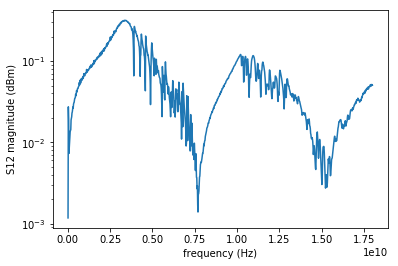

In [17]:
s12_magnitude = np.absolute(snp_data_dict["S12_re"] + 1j * snp_data_dict["S12_im"])

fig, ax = plt.subplots(1)
line, = ax.plot(snp_data_dict["frequency"], s12_magnitude)
ax.set_yscale('log')
ax.set_xlabel("frequency (Hz)")
ax.set_ylabel("S12 magnitude (dBm)")

# Managing traces

In [18]:
# Add a trace on a new channel
channel = pna.add_channel()
trace_s21 = channel.add_trace("S21")  # We need a trace in the rest of the notebook so lets add one again 

In [19]:
# Verify that we see our trace in the list 
channel.trace

[<Trace Type: S21>]

In [20]:
# extract the trace from the list
trace = channel.trace[0]
print(trace is trace_s21)

True


In [21]:
# Delete the trace
trace.delete()

In [22]:
# We should not be able to communicate with the instrument through the interface of the deleted trace
try: 
    trace.log_magnitude()
except RuntimeError as e: 
    print("this does not work anymore")
    print(e)

this does not work anymore
('Trace is not present on the instrument (anymore). It was either deleted or never uploaded in the first place', 'setting pna_CH2_S21_format to MLOG', 'getting pna_CH2_S21_log_magnitude')


In [23]:
# The trace should not be present anymore in the list 
channel.trace

[]

In [24]:
# We can however re-upload the trace to the instrument 
trace.upload_to_instrument()

In [25]:
channel.trace

[<Trace Type: S21>]

In [26]:
trace_s21.name

'pna_CH2_S21'

In [27]:
print(trace_s21)

<Trace Type: S21>
